In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
import tensorflow_addons as tfa  # thư viện cho Attention
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Input, Attention,concatenate
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Dense, Softmax, Concatenate
import tensorflow as tf
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [22]:
data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\train_data2.csv') 
data.set_index('Ngay', inplace=True)

In [23]:
# Chuẩn hóa dữ liệu để đưa về khoảng [0, 1] để dễ xử lý khi đưa vào mô hình
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [24]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 0])  # 'mucNuocHN' là cột đầu tiên
    return np.array(sequences), np.array(targets)

In [25]:
sequence_length = 1 # Sử dụng số ngày trước để dự báo ngày tiếp theo
X, y = create_sequences(data_scaled, sequence_length)

In [26]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [27]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [28]:
class DropAttention(Layer):
    def __init__(self, d_model, num_heads, dropout_rate=0.1):
        super(DropAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.dropout_rate = dropout_rate

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)

        self.dense = Dense(d_model)
        self.dropout = Dropout(self.dropout_rate)

    def split_heads(self, x, batch_size):
        """Chia chiều cuối cùng thành (num_heads, depth)."""
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def scaled_dot_product_attention(self, q, k, v, mask=None):
        """Tính toán attention weights."""
        matmul_qk = tf.matmul(q, k, transpose_b=True)

        # Scale matmul_qk
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # Softmax to get attention weights
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        # Drop some attention weights
        attention_weights = self.dropout(attention_weights, training=True)

        output = tf.matmul(attention_weights, v)

        return output, attention_weights

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len, depth)

        # Scaled dot-product attention with dropout applied
        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len, d_model)

        return output, attention_weights


In [29]:
# 2. Xây dựng mô hình với LSTM và Attention
input_layer = Input(shape=(X.shape[1], X.shape[2]))
lstm_out = LSTM(64, return_sequences=True)(input_layer)

In [30]:
# Áp dụng lớp GlobalSelfAttention
drop_attention_layer = DropAttention(d_model=64, num_heads=4, dropout_rate=0.1)
attention_output, attention_weights = drop_attention_layer(lstm_out, lstm_out, lstm_out)
concat_output = Concatenate()([lstm_out, attention_output])

In [31]:
# Lớp đầu ra
lstm_out_attention = LSTM(32)(concat_output)
output_layer = Dense(1)(lstm_out_attention)

In [32]:
# Khởi tạo và biên dịch mô hình
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1, 7)]               0         []                            
                                                                                                  
 lstm_2 (LSTM)               (None, 1, 64)                18432     ['input_2[0][0]']             
                                                                                                  
 drop_attention_1 (DropAtte  ((None, None, 64),           16640     ['lstm_2[0][0]',              
 ntion)                       (None, 4, None, None))                 'lstm_2[0][0]',              
                                                                     'lstm_2[0][0]']              
                                                                                            

In [33]:
def nse(y_true, y_pred):
    return 1 - sum((y_true - y_pred)**2) / sum((y_true - np.mean(y_true))**2)

In [34]:
# 3. Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
64/64 [==============================] - 8s 30ms/step - loss: 0.0174 - val_loss: 0.0049
Epoch 2/50
64/64 [==============================] - 1s 22ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 3/50
64/64 [==============================] - 1s 17ms/step - loss: 0.0014 - val_loss: 9.3619e-04
Epoch 4/50
64/64 [==============================] - 1s 11ms/step - loss: 8.5672e-04 - val_loss: 0.0011
Epoch 5/50
64/64 [==============================] - 1s 12ms/step - loss: 7.0248e-04 - val_loss: 5.2218e-04
Epoch 6/50
64/64 [==============================] - 1s 10ms/step - loss: 6.2524e-04 - val_loss: 6.5083e-04
Epoch 7/50
64/64 [==============================] - 1s 11ms/step - loss: 6.3566e-04 - val_loss: 7.5170e-04
Epoch 8/50
64/64 [==============================] - 1s 12ms/step - loss: 5.4531e-04 - val_loss: 6.6356e-04
Epoch 9/50
64/64 [==============================] - 1s 13ms/step - loss: 5.6467e-04 - val_loss: 4.9524e-04
Epoch 10/50
64/64 [==============================] - 1s 10ms/

In [35]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R² (R-squared):", r2)

# Tính NSE
nse_value = nse(y_test.flatten(), y_pred.flatten())
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

# Tính MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

16/16 [==============================] - 1s 4ms/step
R² (R-squared): 0.9623290136954824
Nash-Sutcliffe Efficiency (NSE): 0.9623290136954825
Mean Absolute Error (MAE): 0.017987203987962542
Root Mean Squared Error (RMSE): 0.023916914581490017


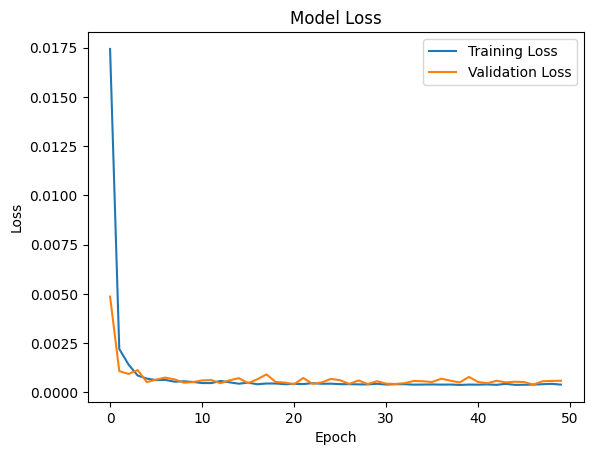

In [36]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
# 5. Vẽ đồ thị dự báo so sánh với thực tế cho từng mực nước
data_test = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\test_data2_1.csv') 
data_test['Ngay'] = pd.to_datetime(data_test['Ngay'], format='%d/%m/%Y')
data_test.set_index('Ngay', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_test)

In [38]:
# Chuẩn hóa dữ liệu test bằng scaler đã huấn luyện
data_test_scaled = scaler.transform(data_test)

# Tạo các mẫu test từ dữ liệu test
X_test_new, y_test_new = create_sequences(data_test_scaled,sequence_length)

# Định dạng lại dữ liệu test để phù hợp với mô hình
X_test_new = np.reshape(X_test_new, (X_test_new.shape[0], X_test_new.shape[1], X_test_new.shape[2]))

In [39]:
predictions_new = model.predict(X_test_new)
num_columns = data_test_scaled.shape[1]
# Chuyển đổi giá trị dự đoán và thực tế về mực nước ban đầu
predictions_new_original = scaler.inverse_transform(
    np.concatenate((predictions_new, np.zeros((predictions_new.shape[0], num_columns - predictions_new.shape[1]))), axis=1)
)[:, 0]

# Thêm đủ các cột phụ vào y_test_new để khớp với số cột của scaler
y_test_new_original = scaler.inverse_transform(
    np.concatenate((y_test_new.reshape(-1, 1), np.zeros((y_test_new.shape[0], num_columns - 1))), axis=1)
)[:, 0]

24/24 [==============================] - 2s 5ms/step


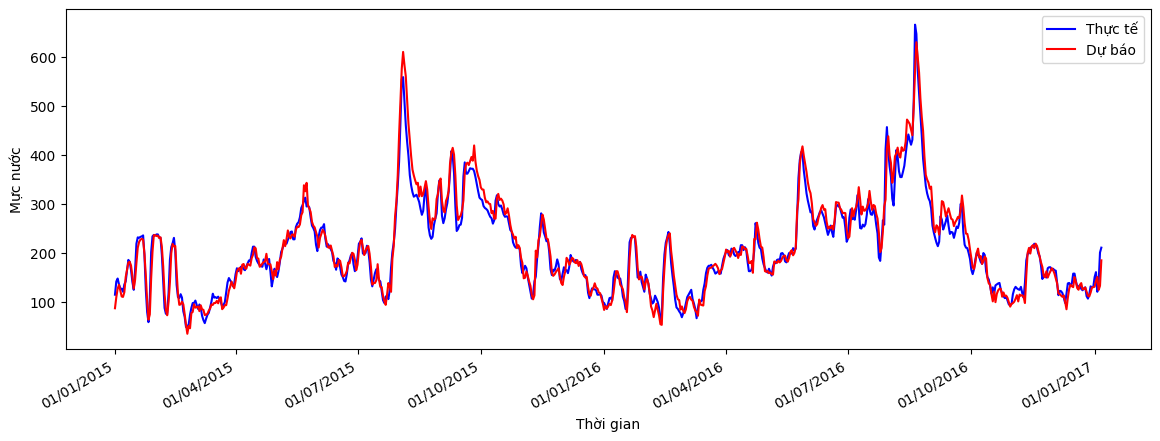

In [40]:
# Đảm bảo các mảng có cùng kích thước
import matplotlib.dates as mdates 
min_length = min(len(data_test.index), len(y_test_new_original), len(predictions_new_original))

# Cắt ngắn mảng theo độ dài nhỏ nhất
dates = data_test.index[:min_length]
y_test_new_original = y_test_new_original[:min_length]
predictions_new_original = predictions_new_original[:min_length]

# Vẽ biểu đồ
plt.figure(figsize=(14, 5))
plt.plot(dates, y_test_new_original, label='Thực tế', color='blue')
plt.plot(dates, predictions_new_original, label='Dự báo', color='red')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước')

# Định dạng ngày tháng
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()
